<a href="https://colab.research.google.com/github/parham-nasiri/gpu_prediction/blob/main/XG_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

In [101]:
from google.colab import files
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/gpu_data.txt'

#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
with open(file_path, "r") as f:
#with open("gpu_data.txt", "r") as f:
  data = json.load(f)
  print(type(data))

<class 'dict'>


In [103]:
def parse_raw_json(data):
    all_rows = []

    for gpu_entry in data:
        gpu_name = gpu_entry["metric"]["gpu"]
        values = gpu_entry["values"]

        for ts, val in values:
            all_rows.append({
                "timestamp": int(ts),
                "gpu_id": gpu_name,
                "available": int(val)
            })

    df = pd.DataFrame(all_rows)
    return df

In [104]:
def convert_timestamp(df, timezone="UTC"):
    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)

    if timezone != "UTC":
        df["datetime"] = df["datetime"].dt.tz_convert(timezone)

    return df

In [105]:
def basic_cleaning(df):

    df = df.drop_duplicates(subset=["gpu_id", "datetime"])
    df = df.sort_values(["gpu_id", "datetime"])
    df = df.reset_index(drop=True)

    return df


def ensure_regular_interval(df):

    final_dfs = []

    for gpu in df["gpu_id"].unique():
        temp = df[df["gpu_id"] == gpu].copy()
        temp = temp.set_index("datetime")

        full_index = pd.date_range(
            start=temp.index.min(),
            end=temp.index.max(),
            freq="5T",
            tz=temp.index.tz
        )

        temp = temp.reindex(full_index)

        temp["gpu_id"] = gpu

        temp["available"] = temp["available"].ffill()

        temp = temp.reset_index().rename(columns={"index": "datetime"})
        final_dfs.append(temp)

    df_final = pd.concat(final_dfs)
    df_final = df_final.sort_values(["gpu_id", "datetime"])
    df_final = df_final.reset_index(drop=True)

    return df_final




In [106]:
def aggregate_hourly(df):

    df["datetime_hour"] = df["datetime"].dt.floor("H")

    hourly = (
        df.groupby(["gpu_id", "datetime_hour"])["available"].mean().reset_index())

    hourly = hourly.rename(columns={"available": "available_hourly_mean"})

    return hourly


def validate_hourly_data(hourly_df):

    print("Number of GPUs:", hourly_df["gpu_id"].nunique())
    print("Date range:", hourly_df["datetime_hour"].min(), "to", hourly_df["datetime_hour"].max())

    print("Missing values:", hourly_df.isna().sum().sum())

    duplicates = hourly_df.duplicated(subset=["gpu_id", "datetime_hour"]).sum()
    print("Duplicate rows:", duplicates)


def run_data_engineering_pipeline(data, timezone="UTC"):
    df = parse_raw_json(data)
    df = convert_timestamp(df, timezone=timezone)
    df = basic_cleaning(df)
    df = ensure_regular_interval(df)
    hourly = aggregate_hourly(df)
    validate_hourly_data(hourly)

    return hourly

In [107]:
real_data = data["data"]["result"]
hourly_df = run_data_engineering_pipeline(real_data, timezone="UTC")
print("Number of GPUs:", hourly_df["gpu_id"].nunique())
print("Date range:", hourly_df["datetime_hour"].min(), "to", hourly_df["datetime_hour"].max())


Number of GPUs: 8
Date range: 2025-12-23 09:00:00+00:00 to 2026-02-21 09:00:00+00:00
Missing values: 0
Duplicate rows: 0
Number of GPUs: 8
Date range: 2025-12-23 09:00:00+00:00 to 2026-02-21 09:00:00+00:00


/tmp/ipython-input-1179/1056080562.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
/tmp/ipython-input-1179/1056080562.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
/tmp/ipython-input-1179/1056080562.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
/tmp/ipython-input-1179/1056080562.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
/tmp/ipython-input-1179/1056080562.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(
/tmp/ipython-input-1179/1056080562.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead

In [108]:
print(hourly_df.head())

  gpu_id             datetime_hour  available_hourly_mean
0   3090 2025-12-23 09:00:00+00:00               8.545455
1   3090 2025-12-23 10:00:00+00:00               8.666667
2   3090 2025-12-23 11:00:00+00:00               8.583333
3   3090 2025-12-23 12:00:00+00:00              10.250000
4   3090 2025-12-23 13:00:00+00:00              11.916667


In [109]:
import matplotlib.dates as mdates

def plot_single_gpu_series(hourly_df, gpu_name, days=7):
    df = hourly_df[hourly_df["gpu_id"] == gpu_name].copy()
    df = df.sort_values("datetime_hour")

    end_date = df["datetime_hour"].max()
    start_date = end_date - pd.Timedelta(days=days)
    df = df[df["datetime_hour"] >= start_date]

    plt.figure(figsize=(10,5))
    plt.plot(df["datetime_hour"], df["available_hourly_mean"])

    plt.title(f"Last {days} Days - GPU {gpu_name}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Available (Hourly Mean)")

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

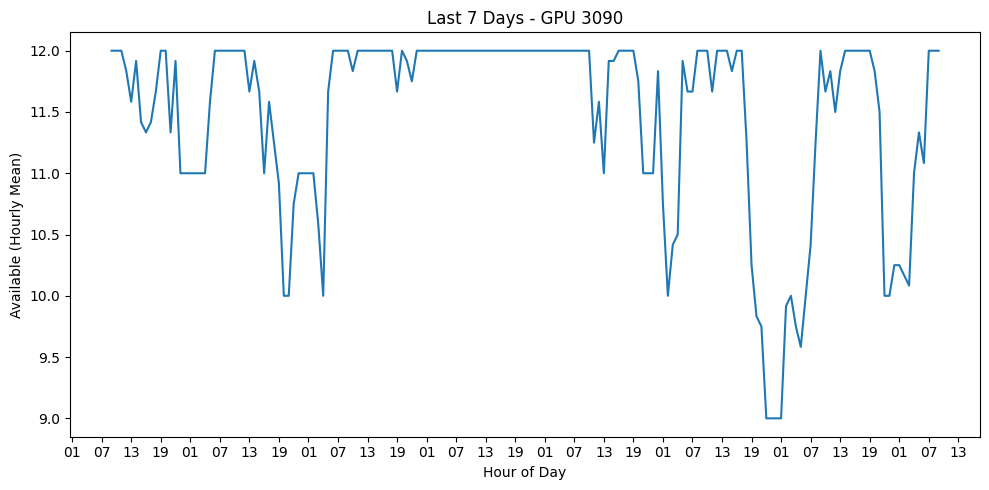

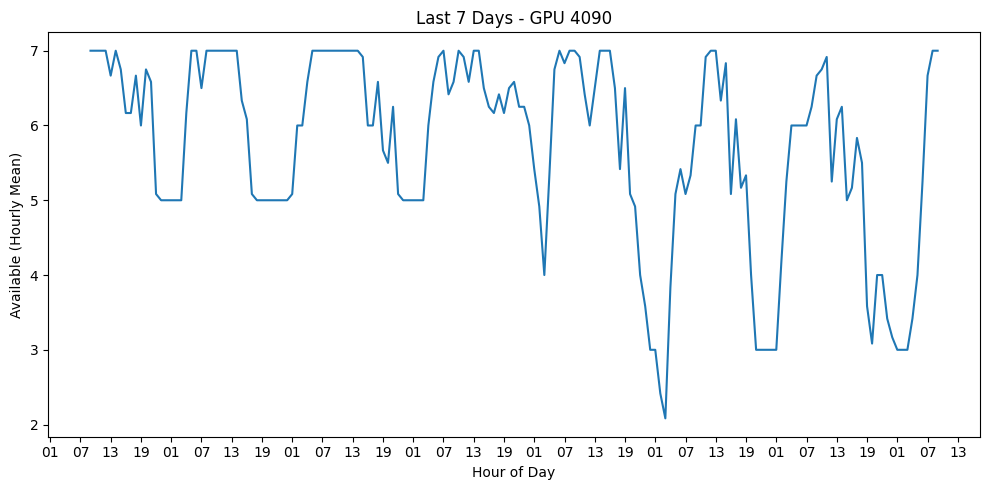

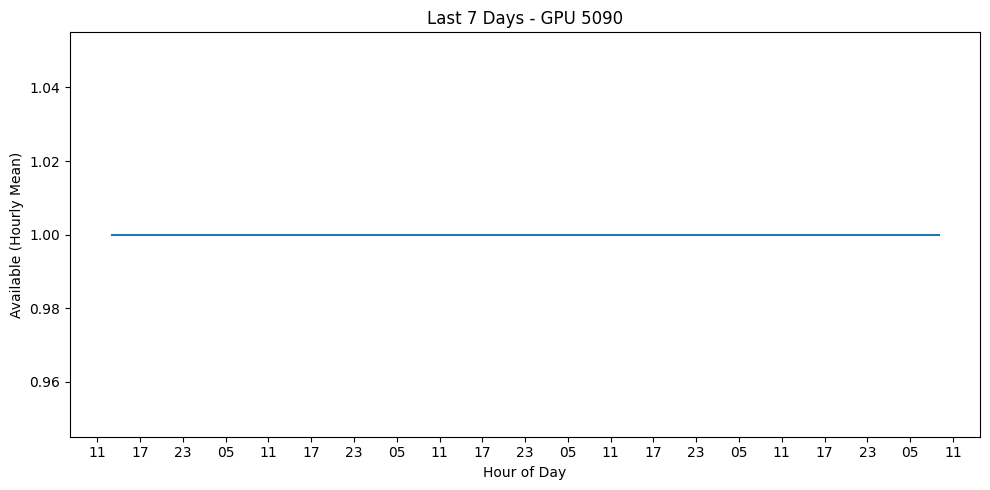

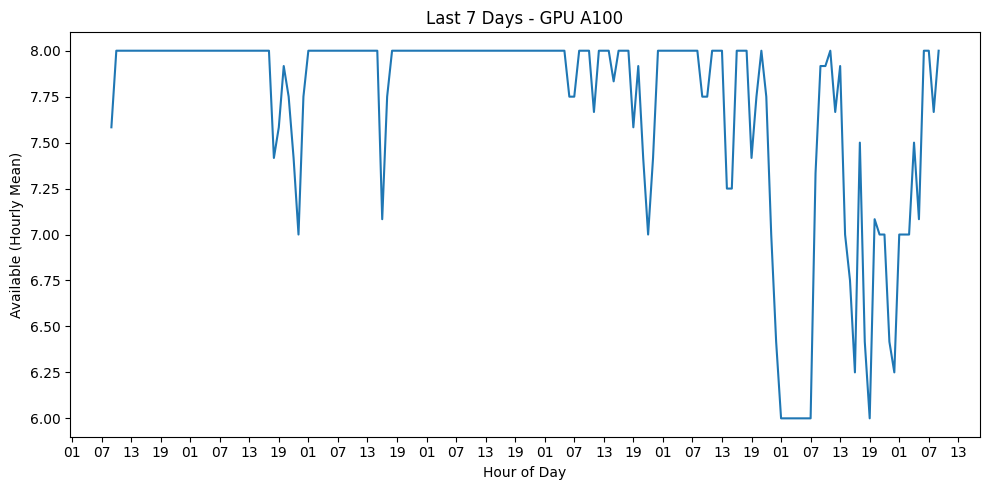

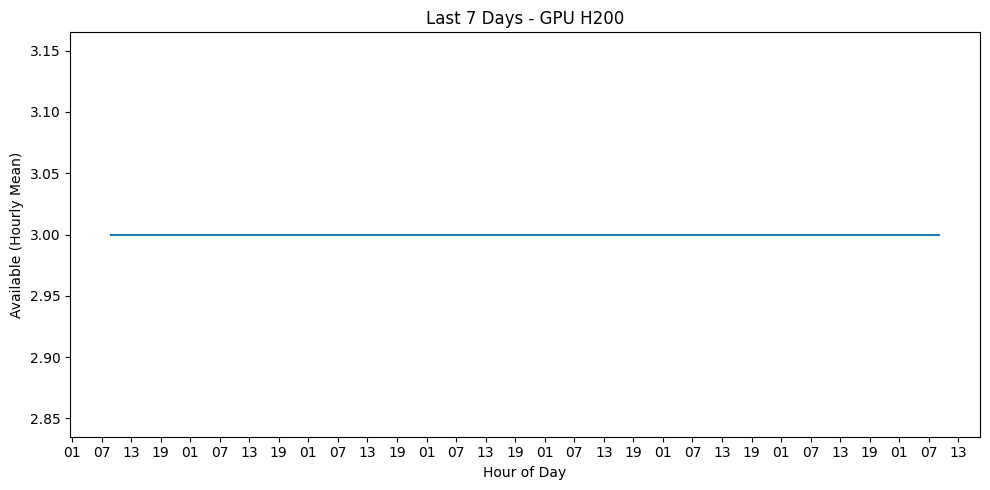

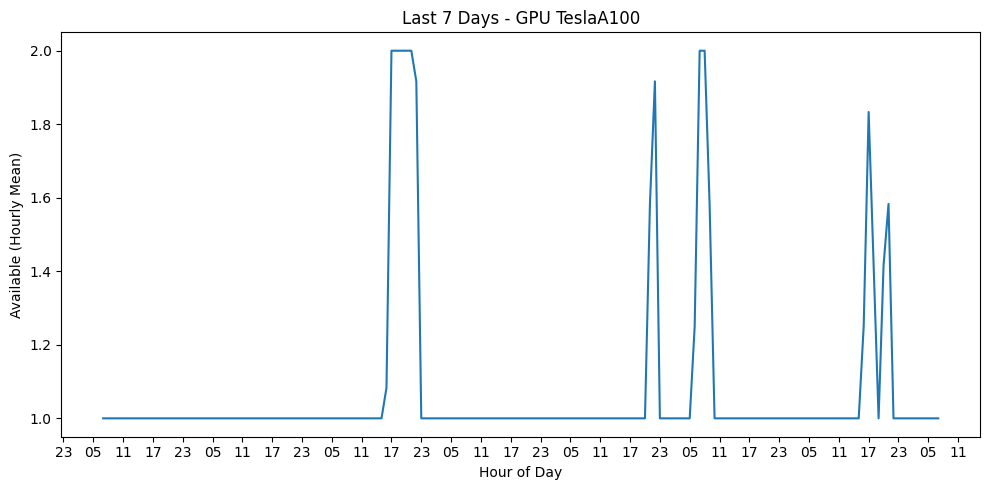

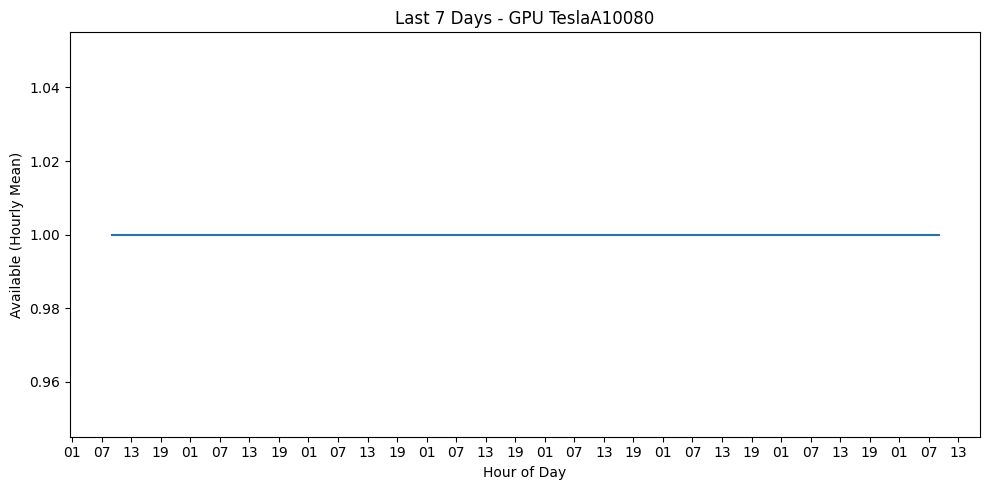

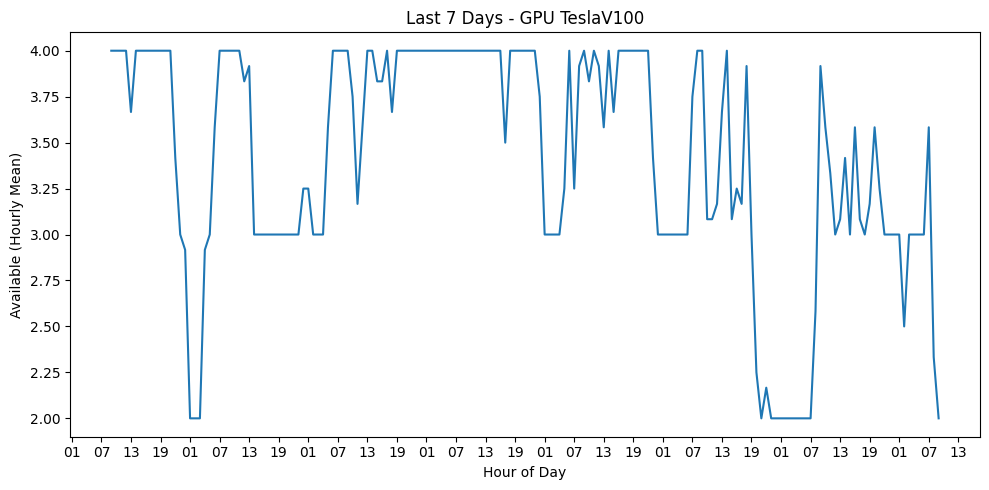

In [110]:
gpus = hourly_df["gpu_id"].unique()

for gpu in gpus:
  plot_single_gpu_series(hourly_df, gpu)


In [111]:
def plot_weekly_seasonality(hourly_df, gpu_name):
    df = hourly_df[hourly_df["gpu_id"] == gpu_name].copy()

    df["day_of_week"] = df["datetime_hour"].dt.dayofweek

    weekly_pattern = (
        df.groupby("day_of_week")["available_hourly_mean"]
        .mean()
        .reset_index()
    )

    plt.figure()
    plt.plot(weekly_pattern["day_of_week"], weekly_pattern["available_hourly_mean"])
    plt.title(f"Weekly Seasonality - GPU {gpu_name}")
    plt.xlabel("Day of Week (0=Mon)")
    plt.ylabel("Mean Availability")
    plt.tight_layout()
    plt.show()

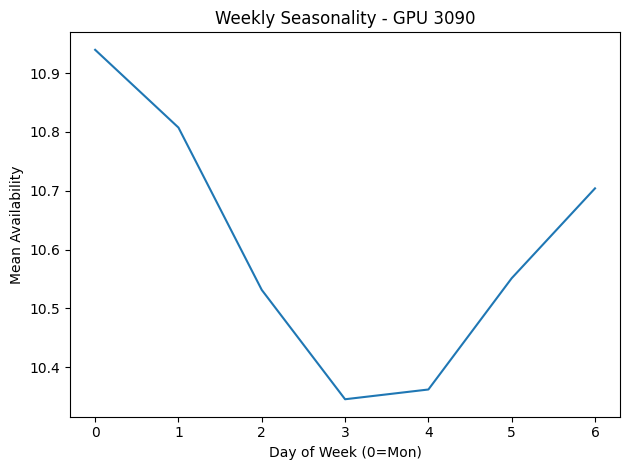

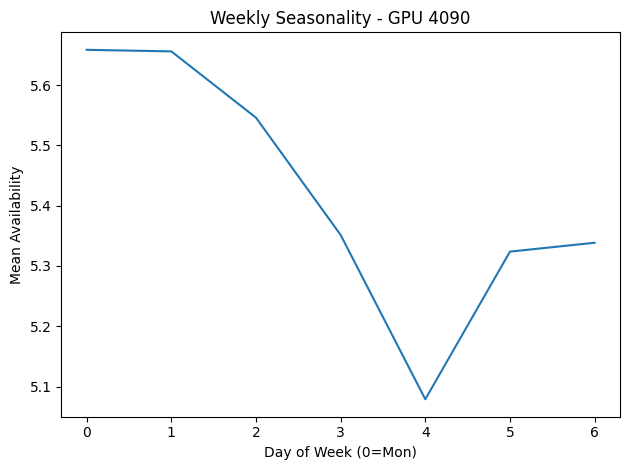

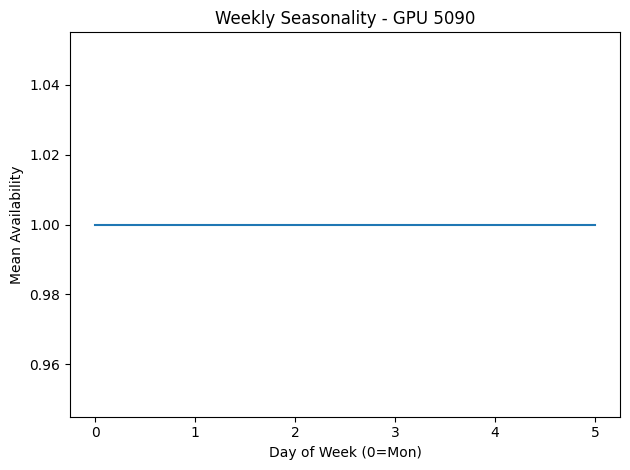

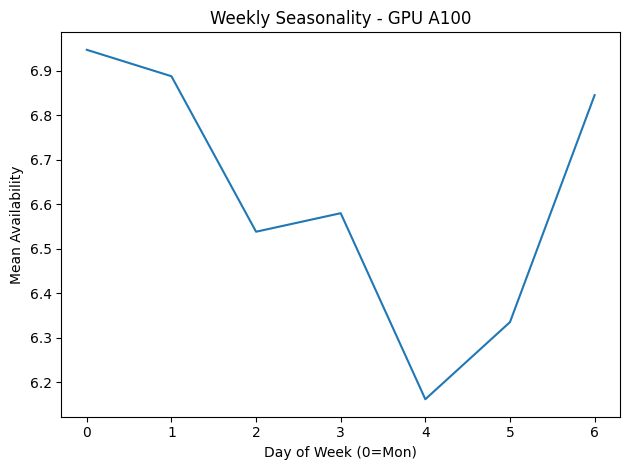

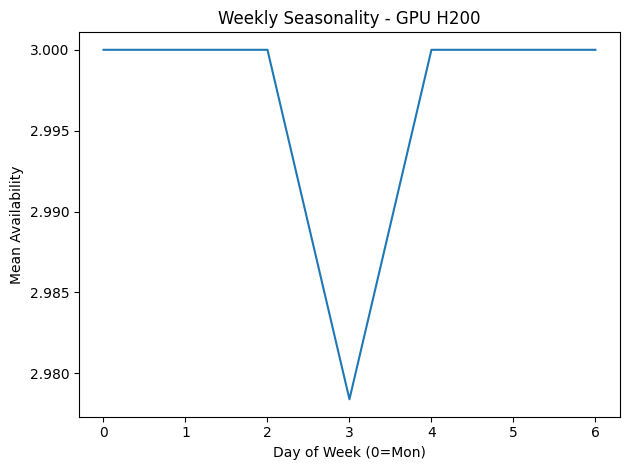

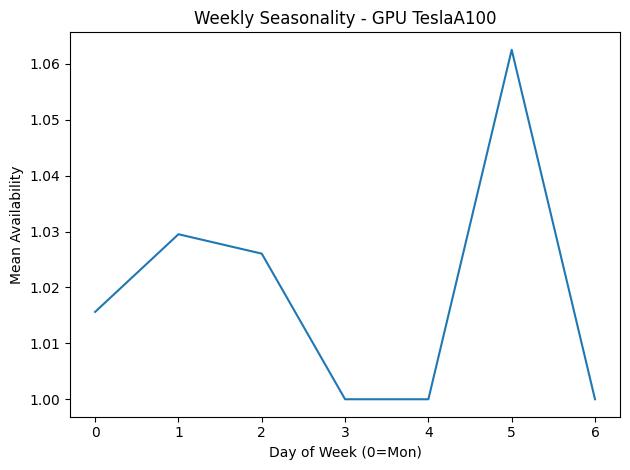

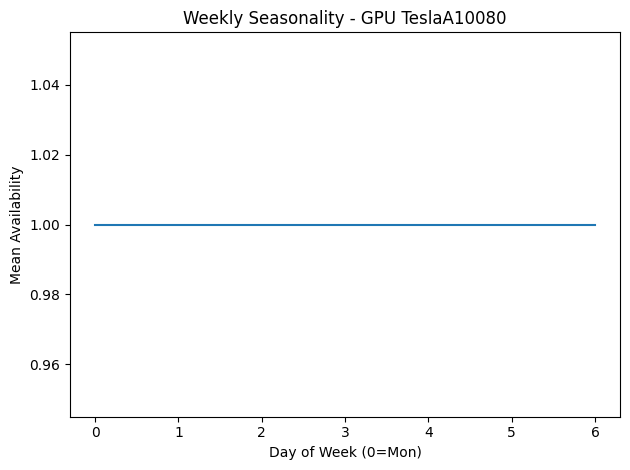

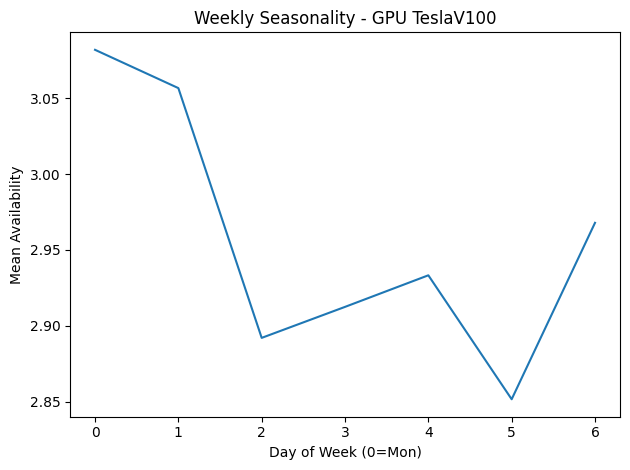

In [112]:
gpus = hourly_df["gpu_id"].unique()
for gpu in gpus:
  plot_weekly_seasonality(hourly_df, gpu)

In [113]:
def plot_rolling_mean(hourly_df, gpu_name, window=24*7):
    df = hourly_df[hourly_df["gpu_id"] == gpu_name].copy()
    df = df.sort_values("datetime_hour")

    df["rolling_mean"] = df["available_hourly_mean"].rolling(window).mean()

    plt.figure()
    plt.plot(df["datetime_hour"], df["rolling_mean"])
    plt.title(f"Rolling Mean ({window}h) - GPU {gpu_name}")
    plt.xlabel("Time")
    plt.ylabel("Rolling Mean")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

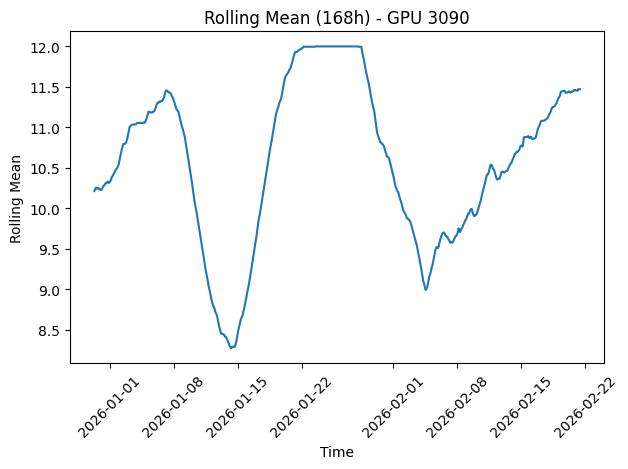

In [114]:
plot_rolling_mean(hourly_df, "3090")

In [115]:
def compute_gpu_correlation(hourly_df):
    pivot = hourly_df.pivot(
        index="datetime_hour",
        columns="gpu_id",
        values="available_hourly_mean"
    )

    corr = pivot.corr()

    return corr

In [116]:
compute_gpu_correlation(hourly_df)

gpu_id,3090,4090,5090,A100,H200,TeslaA100,TeslaA10080,TeslaV100
gpu_id,,,,,,,,
3090,1.000000,0.702830,NaN,0.466601,0.056988,0.119228,NaN,0.475674
4090,0.702830,1.000000,NaN,0.514653,-0.043787,0.081679,NaN,0.480413
5090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100,0.466601,0.514653,NaN,1.000000,-0.017114,-0.061765,NaN,0.367863
H200,0.056988,-0.043787,NaN,-0.017114,1.000000,NaN,NaN,0.010286
TeslaA100,0.119228,0.081679,NaN,-0.061765,NaN,1.000000,NaN,-0.008680
TeslaA10080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TeslaV100,0.475674,0.480413,NaN,0.367863,0.010286,-0.008680,NaN,1.000000
